In [ ]:
pip install keras_applications 

     |████████████████████████████████| 50 kB 2.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, MaxPool2D
from keras.layers.core import Lambda
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models, losses
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import *
#from keras.utils import multi_gpu_model
from matplotlib import pyplot as plt
from keras.models import load_model
import keras.backend as K
from keras.layers.core import Lambda
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_v3 import InceptionV3 
from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16
#from keras.applications.resnet50 import ResNet50
from keras_applications.resnet import ResNet50
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
import os
from keras.layers import *

In [ ]:
def GC_Block(inputs,ratio = 16):
  shape=K.int_shape(inputs)
  ch = shape[3]
  conv =  Conv2D(1,1, padding='same') (inputs)
  print(conv.shape)
  d = shape[1]*shape[2]
  reshpe = tf.keras.layers.Reshape((1,1,d),input_shape=(1,1,shape[1],shape[2]))(conv)
  print(reshpe.shape)
  sm = tf.keras.layers.Softmax()(reshpe)
  print(sm.shape)


  reshpe = tf.keras.layers.Reshape((shape[3],d),input_shape=(shape[1],shape[2],shape[3]))(inputs)
  print(reshpe.shape)
  mul = tf.keras.layers.Dot(axes=-1)([reshpe,sm])
  #mul = tf.keras.layers.Attention(use_scale=False, score_mode="dot")([reshpe,sm])
  new_shape = K.int_shape(mul)
  print(new_shape)
  reshpe = tf.keras.layers.Reshape((1,1,new_shape[1]),input_shape=(new_shape[1],new_shape[2],new_shape[3]))(mul)
  print(reshpe.shape)
  x = Conv2D(ch//ratio,1)(reshpe)
  print(x.shape)
  x = tf.keras.layers.LayerNormalization() (x)
  print(x.shape)
  x = tf.keras.layers.ReLU()(x)
  x = Conv2D(ch,1, padding='same')(x)
  print(x.shape)
  gc_attend = tf.keras.layers.Add()([inputs, x])
  print(gc_attend.shape)

  return gc_attend

def smooth_curve(points, factor=0.6):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points    
   
def plotmodel(history,name):
    
    acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    #val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,smooth_curve(acc))
    #plt.plot(epochs,smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    #plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.legend(['train_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs,smooth_curve(loss))
    #plt.plot(epochs,smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    #plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.legend(['train_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
def get_base_model(model_name,image_size):
    if model_name =='vgg16':
        base_model=VGG16              (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='resnet50':
        base_model=ResNet50           (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='xception':
        base_model=Xception           (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='densenet121':    #done acc = 55% epochs:30
        base_model=DenseNet121       (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='mobilenet0.75': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=0.75,input_shape=(image_size,image_size,3))
    if model_name =='mobilenet1.0': #acc = 60.41% loss = 1.21 epochs:70
        base_model=MobileNet         (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='mobilenetv2':
        base_model=MobileNetV2      (include_top=False,weights='imagenet',alpha=1.0,input_shape=(image_size,image_size,3))
    if model_name =='inceptionv3':   
        base_model=InceptionV3       (include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='inceptionv2':
        base_model=tf.keras.applications.InceptionResNetV2 (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    if model_name =='efficientnetB0':
        base_model = tf.keras.applications.EfficientNetB0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='efficientNetV2B0':
        base_model = tf.keras.applications.EfficientNetV2B0 (include_top=False, weights = 'imagenet',input_shape = (image_size,image_size,3))
    if model_name =='nasnet':
        base_model=tf.keras.applications.NASNetMobile (include_top=False, weights='imagenet',input_shape=(image_size,image_size,3))
    
    return base_model

def train_model(model,dataset,image_size,batch_size,save_name,lr1,lr2,Epochs1,Epochs2):
    
    dataParam={'messidor': [960,240,2,'../content/drive/MyDrive/Dataset/Messidor_512/train',
                            '../content/drive/MyDrive/Dataset/Messidor_512/test'],
               'kaggle': [30000,5126,5,'./data/kaggle/train','./data/kaggle/valid'],
               'DDR':   [9851,2503,5,'./data/DDR/train','./data/DDR/valid']} 
    
    train_num,valid_num,classes,train_dir,test_dir = dataParam[dataset]
    
    train=ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=90)          
    valid = ImageDataGenerator()
    train_data=train.flow_from_directory(train_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = True,
                                         batch_size=batch_size)
    valid_data=valid.flow_from_directory(test_dir,
                                         target_size=(image_size,image_size),
                                         shuffle = False,
                                         batch_size=batch_size)

    lr_decay=ReduceLROnPlateau(monitor='loss', factor=0.8, patience=3, verbose=1)
    #save_model=ModelCheckpoint('new/'+save_name+'{epoch:02d}.h5', monitor='val_loss',period=10)
    
    filepath = "efficientnetB0+GC_Block.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='acc',verbose=1, save_best_only=True, mode='max')

    for layer in base_model.layers:
        layer.trainable = False   
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr1,decay=0.00001),loss=loss_fun,metrics=['acc'])
    model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs1, 
                        workers=2,
                        callbacks=[lr_decay,checkpoint])   
    
    for layer in base_model.layers:
        layer.trainable = True
        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr2,decay=0.00001),loss=loss_fun,metrics=['acc'])
    history=model.fit(train_data,
                        steps_per_epoch=train_num/batch_size,
                        epochs=Epochs2,
                        workers=2,
                        callbacks=[lr_decay,checkpoint])
    
    score = model.evaluate(valid_data,batch_size = 64)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return history,model,valid_data

In [ ]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"    
loss_fun= 'binary_crossentropy'  
gpu_num=1
k=3
lr1=0.005
lr2=0.0001
batch_size= 16
image_size=512
classes=2

base_model=get_base_model('efficientnetB0',image_size)  
base_in=base_model.input
base_out=base_model.output

shape = K.int_shape(base_out)
channel_val = shape[3]/2
red_feat = tf.keras.layers.Conv2D(channel_val,1,padding='same')(base_out)
x=GC_Block(red_feat)
#base_out=Category_attention_block(x,classes,k)

shape=K.int_shape(x)  
x=GlobalAveragePooling2D()(x)
out=Dense(classes,activation='softmax')(x)

parallel_model=keras.Model(base_model.input,out)
parallel_model.summary()

(None, 16, 16, 1)
(None, 1, 1, 256)
(None, 1, 1, 256)
(None, 640, 256)
(None, 640, 1, 1)
(None, 1, 1, 640)
(None, 1, 1, 40)
(None, 1, 1, 40)
(None, 1, 1, 640)
(None, 16, 16, 640)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 512, 512, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 512, 512, 3)  7          ['rescaling_2[0][0]']            
 )            

In [ ]:
history,model,valid_data=train_model(parallel_model,
                                     'messidor',
                                     image_size,
                                     batch_size,
                                     'efficientnetB0',
                                     lr1,lr2,1,80)

Found 960 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
60/60 [==============================] - ETA: 0s - loss: 0.8067 - acc: 0.6177
Epoch 1: acc improved from -inf to 0.61771, saving model to efficientnetB0+GC_Block.hdf5
60/60 [==============================] - 62s 870ms/step - loss: 0.8067 - acc: 0.6177 - lr: 0.0050
Epoch 1/80
60/60 [==============================] - ETA: 0s - loss: 0.5650 - acc: 0.6958
Epoch 1: acc improved from 0.61771 to 0.69583, saving model to efficientnetB0+GC_Block.hdf5
60/60 [==============================] - 103s 2s/step - loss: 0.5650 - acc: 0.6958 - lr: 1.0000e-04
Epoch 2/80
60/60 [==============================] - ETA: 0s - loss: 0.4692 - acc: 0.7875
Epoch 2: acc improved from 0.69583 to 0.78750, saving model to efficientnetB0+GC_Block.hdf5
60/60 [==============================] - 93s 2s/step - loss: 0.4692 - acc: 0.7875 - lr: 1.0000e-04
Epoch 3/80
60/60 [==============================] - ETA: 0s - loss: 0.4290 - acc: 0.7885
Epo

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[9.86856282e-01 1.31437415e-02]
 [9.99977231e-01 2.28108493e-05]
 [9.99996662e-01 3.34390529e-06]
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 3.80955800e-22]
 [1.00000000e+00 4.68783606e-12]
 [1.00000000e+00 1.30117015e-22]
 [9.93561745e-01 6.43821852e-03]
 [1.00000000e+00 3.96197975e-29]
 [1.00000000e+00 1.21567808e-13]
 [1.00000000e+00 1.95766292e-18]
 [1.00000000e+00 6.71658692e-13]
 [1.00000000e+00 2.70606787e-19]
 [1.00000000e+00 2.24083176e-14]
 [1.00000000e+00 0.00000000e+00]
 [9.99967217e-01 

Text(69.0, 0.5, 'Truth')

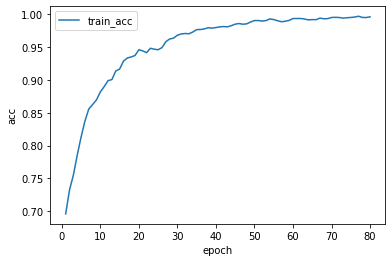

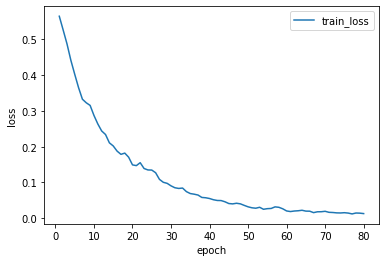

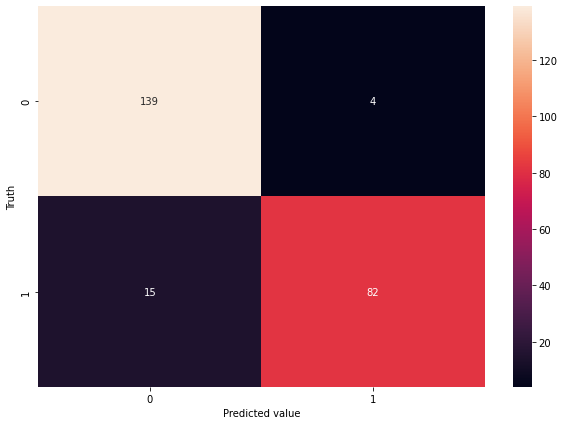

In [ ]:
plotmodel(history,'efficientnetB0')            

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

Y_pred = model.predict(valid_data, 240 // 4)
#print(Y_pred.shape)
#print(type(Y_pred))
print(valid_data.classes)  
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
#print(y_pred)
print('Confusion Matrix')
matrix = confusion_matrix(valid_data.classes, y_pred)

print(confusion_matrix(valid_data.classes, y_pred))
print('Classification Report')
target_names = ['non-referable', 'referable']
print(classification_report(valid_data.classes, y_pred, target_names=target_names))

plt.figure(figsize = (10,7))
sn.heatmap(matrix,annot=True,fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Truth')   

In [ ]:
pip install plot_metric

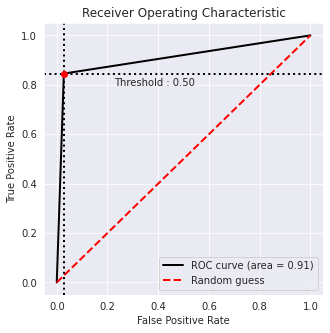

In [ ]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
y_true = valid_data.classes
y_probas = y_pred
bc = BinaryClassification(y_true, y_probas, labels=['non-referable', 'referable'])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()